# Actor-Critic Algorithm
In this notebook, you'll code The Actor-Critic Algorithm from scratch: .

Actor-Critic algorithm is a *Policy-based method* that aims to reduce the variance of the Reinforce algorithm and train our agent faster and better by using a combination of Policy-Based and Value-Based methods


To test its robustness, we're going to train it in LunarLander-v2 environment

## Import the packages

In [1]:
!pip install swig
!pip install gymnasium[box2d]
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 91.0 MB/s eta 0:00:00:00:0100:01
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=495258 sha256=27e44f3115c56ad654ec069e37ea7f0cb9c0eae6a7a6b95a9b1f0d3d16b682a6
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gymnasium as gym

## Check if we have a GPU
- Let's check if we have a GPU `device:cuda0`

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Agent: Playing LunarLander-v2 🤖
### Lunar Lander environment

> This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

> There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

> The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

> Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.


he episode finishes if:

- the lander crashes (the lander body gets in contact with the moon);

- the lander gets outside of the viewport (x coordinate is greater than 1);

- the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body:

In [4]:
#env_id = "CartPole-v1"
env_id="LunarLander-v2"
# Create the env
env = gym.make(env_id)


# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n
print(s_size, a_size)

8 4


## Let's build the A2C algo

In [5]:
#Using a neural network to learn our actor (policy) parameters

class Actor(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):

        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [6]:
#Using a neural network to learn state value
class Critic(nn.Module):

    #Takes in state
    def __init__(self, s_size, h_size):
        super(Critic, self).__init__()

        # two fully connected layers
        self.input_layer = nn.Linear(s_size, h_size)
        self.output_layer = nn.Linear(h_size, 1)

    def forward(self, x):

        #input layer
        x = self.input_layer(x)

        #activiation relu
        x = F.relu(x)

        #get state value
        state_value = self.output_layer(x)

        return state_value

# Building the parts of our algorithm #
The main steps for building a A2C Algo are:
1. Generates a trajectory
2. Compute the discounted returns
3. Standardization of the returns
4. Train critic network
5. Train actor network


In [7]:
 def generate_trajectory(actor, critic, max_t):
        saved_log_probs = []
        rewards = []
        state_values=[]

        state, _ = env.reset()
        for t in range(max_t):
            state=torch.from_numpy(state).float().unsqueeze(0).to(device)

            action, log_prob = actor.act(state)



            # get the state value from th critic network
            state_val= critic(state)


            next_state, reward, done,truncated , _ = env.step(action)

            # add te obtained results to their relative lists ==> saved_log_probs, rewards, state_values
            rewards.append(reward)
            saved_log_probs.append(log_prob)
            state_values.append(state_val)
            # add code here
            # add code here
            # add code here

            state=next_state

            if done:

                break

        return  saved_log_probs, rewards, state_values

In [8]:
def computer_cumulative_reward(rewards, max_t,gamma):

        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        for t in range(n_steps)[::-1]:
          disc_return_t = (returns[0] if len(returns)>0 else 0)
          returns.appendleft( rewards[t]+gamma*disc_return_t)
        return returns

In [9]:
def returns_standardization(returns):
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        return returns

In [10]:

def train_actor(actorOptimizer,saved_log_probs, returns,state_values):


        state_values= torch.stack(state_values).squeeze()

        #calculate Advantage for actor
        advantages = returns - state_values.detach()

        #convect the advantages to a tensor
        advantages = torch.tensor(advantages).to(device)

        actor_loss = []
        # compute the actor loss
        for log_prob, advantage in zip(saved_log_probs, advantages):
            actor_loss.append(-log_prob * advantage)


        actor_loss = torch.cat(actor_loss).sum()
        # Backpropagate actor
        actorOptimizer.zero_grad()
        actor_loss.backward()
        actorOptimizer.step()


In [11]:

def train_critic(criticOptimizer, returns,state_values):
        state_values= torch.stack(state_values).squeeze()

        critic_loss=F.mse_loss(state_values,returns)

        # Backpropagate crtic
        criticOptimizer.zero_grad()
        critic_loss.backward()
        criticOptimizer.step()

## Merge all functions into the Actor_Critic method ##

You will now see how the overall **A2C Algo** is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

In [12]:
def Actor_Critic(actor,critic, actorOptimizer,criticOptimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_training_episodes+1):

        # Generate an episode
        saved_log_probs, rewards, state_values = generate_trajectory(actor, critic, max_t)
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # calculate the return
        returns= computer_cumulative_reward(rewards,max_t,gamma)

        ## standardization of the returns is employed to make training more stable
        returns=returns_standardization(returns)

        # Train the Critic network
        train_critic(criticOptimizer, returns,state_values)
        #add code here

        # Train the Actor network
        train_actor(actorOptimizer,saved_log_probs, returns,state_values)
        #add code here



        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

##  Train it
- We're now ready to train our agent.
- But first, we define a variable containing all the training hyperparameters.
- You can change the training parameters (and should 😉)

In [13]:
Lunar_Lander_hyperparameters = {
    "h_size": 256,  
    "n_training_episodes": 10000, 
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 0.99,  #
    "lr": 1e-3,  
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [14]:
# Create actor and place it to the device
Lunar_Lander_actor = Actor(Lunar_Lander_hyperparameters["state_space"], Lunar_Lander_hyperparameters["action_space"], Lunar_Lander_hyperparameters["h_size"]).to(device)

Lunar_Lander_actorOptimizer = optim.Adam(Lunar_Lander_actor.parameters(), lr=Lunar_Lander_hyperparameters["lr"])

In [15]:
# Create critic and place it to the device
Lunar_Lander_critic = Critic(Lunar_Lander_hyperparameters["state_space"], Lunar_Lander_hyperparameters["h_size"]).to(device)
Lunar_Lander_criticOptimizer = optim.Adam(Lunar_Lander_critic.parameters(), lr=Lunar_Lander_hyperparameters["lr"])

In [16]:
scores = Actor_Critic(Lunar_Lander_actor,
                   Lunar_Lander_critic,Lunar_Lander_actorOptimizer,Lunar_Lander_criticOptimizer,
                   Lunar_Lander_hyperparameters["n_training_episodes"],
                   Lunar_Lander_hyperparameters["max_t"],
                   Lunar_Lander_hyperparameters["gamma"],
                   100)

/tmp/ipykernel_30/3061804092.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  advantages = torch.tensor(advantages).to(device)


Episode 100	Average Score: -166.37
Episode 200	Average Score: -133.45
Episode 300	Average Score: -92.72
Episode 400	Average Score: -63.79
Episode 500	Average Score: -54.19
Episode 600	Average Score: -25.81
Episode 700	Average Score: 15.87
Episode 800	Average Score: 82.59
Episode 900	Average Score: 88.89
Episode 1000	Average Score: 118.07
Episode 1100	Average Score: 114.16
Episode 1200	Average Score: 124.12
Episode 1300	Average Score: 158.77
Episode 1400	Average Score: 136.91
Episode 1500	Average Score: 189.30
Episode 1600	Average Score: 173.59
Episode 1700	Average Score: 187.48
Episode 1800	Average Score: 137.37
Episode 1900	Average Score: 183.41
Episode 2000	Average Score: 186.01
Episode 2100	Average Score: 192.26
Episode 2200	Average Score: 204.23
Episode 2300	Average Score: 176.09
Episode 2400	Average Score: 157.51
Episode 2500	Average Score: 187.43
Episode 2600	Average Score: 178.10
Episode 2700	Average Score: 181.20
Episode 2800	Average Score: 192.47
Episode 2900	Average Score: 18

In [17]:
scores= pd.Series(scores, name="scores_Actor")
scores.describe()

count    10000.000000
mean       160.811687
std        132.627638
min       -607.261075
25%         24.374726
50%        231.436770
75%        256.189560
max        322.185649
Name: scores_Actor, dtype: float64

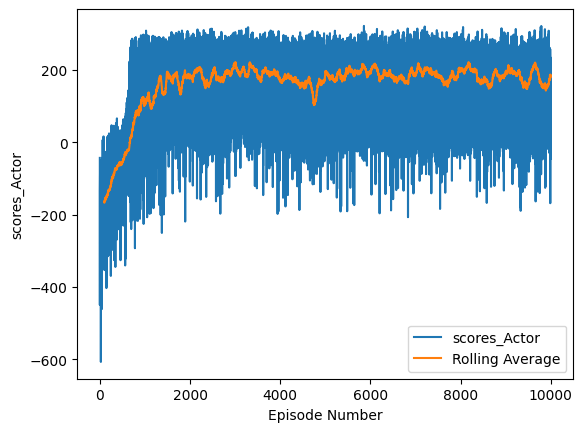

In [18]:
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="scores_Actor")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("scores_Actor")

In [19]:
def evaluate_agent(actor, env, n_eval_episodes, max_t):
  """Evaluates the agent's performance.

  Args:
    actor: The trained actor network.
    env: The Gym environment.
    n_eval_episodes: The number of episodes to run for evaluation.
    max_t: The maximum number of steps per episode.

  Returns:
    A tuple containing the average reward and the average number of steps.
  """
  all_rewards = []
  all_steps = []

  for i_episode in range(1, n_eval_episodes + 1):
    state, _ = env.reset()
    episode_reward = 0
    for t in range(max_t):
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      action, _ = actor.act(state)
      state, reward, done, _, _ = env.step(action)
      episode_reward += reward
      if done:
        break
    all_rewards.append(episode_reward)
    all_steps.append(t + 1)  # Add 1 to count the last step

  avg_reward = np.mean(all_rewards)
  avg_steps = np.mean(all_steps)
  print(f"Evaluation over {n_eval_episodes} episodes:")
  print(f"Average Reward: {avg_reward:.2f}")
  print(f"Average Steps: {avg_steps:.2f}")

  return avg_reward, avg_steps

In [20]:
avg_reward, avg_steps = evaluate_agent(Lunar_Lander_actor, env, Lunar_Lander_hyperparameters["n_evaluation_episodes"], Lunar_Lander_hyperparameters["max_t"])

Evaluation over 10 episodes:
Average Reward: 195.28
Average Steps: 271.60
